<a href="https://colab.research.google.com/github/adammoss/MLiS2/blob/reinforcement_learning/examples/reinforcement_learning/tabular/monte_carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We begin by defining our environment as a class: we need this to have two methods which the agent can interact with, to induce transitions in the state, and to restart the environment after each episode, which we call step and reset respectively. Transition calls _reward, which provides the reward for the transition which just occured, and outputs the new state, reward, and whether the episode has ended to the agent.

In [187]:
class excursions(object):
	"""A simple environment which provides rewards based on excursions."""

	def __init__(self, parameters):
		self.trajectory_length = parameters['trajectory_length']
		self.positivity_bias = parameters['positivity_bias']
		self.target_bias = parameters['target_bias']
		self.action = 0
		self.state = [0, 0]
		self.terminal_state = False

	def _reward(self):
		"""Calculates the reward for the last transition to occur."""
		if self.state[0] < 0:
			reward = -self.positivity_bias * abs(self.state[0])
		else:
			reward = 0
		if self.state[1] == self.trajectory_length:
			reward -= self.target_bias * abs(self.state[0])
		return reward

	def step(self, action):
		"""Updates the environment state based on the input action."""
		self.action = action
		self.state[0] += 2*action - 1
		self.state[1] += 1
		if self.state[1] == self.trajectory_length:
			self.terminal_state = True
		return self.state, self._reward(), self.terminal_state

	def reset(self):
		"""Resets the environment state and terminal boolean."""
		self.action = 0
		self.state = [0, 0]
		self.terminal_state = False

Next, we need our table for the policy, for which we will need some functions from math and numpy.

In [188]:
import math
import numpy as np
import numpy.random

This table will act as the agent, so it needs to be able to output a randomly selected action. The action function calls the _forward function, which simply returns the probability of the first action for the current state.

To learn, it needs to be able to update the probabilities, which is done using the step function. To facilitate this, the eligibility (the derivative of the log of the policy) is output as a second return from action, which the learning algorithm can then input to step when later required.

In [189]:
class two_action_policy_table(object):
	"""A tabular policy for environments where each state has two actions."""

	def __init__(self, dimensions, learning_rate):
		self.table = np.zeros(dimensions)
		self.learning_rate = learning_rate

	def _forward(self, state):
		"""Calculates the probabilitiy of action 1."""
		exponentiated_potential = math.exp(-self.table[state[0]][state[1]])
		return 1/(exponentiated_potential+1)

	def action(self, state):
		"""Returns a random action according to the current policy."""
		action1_probability = self._forward(state)
		random = numpy.random.random() # pylint: disable = no-member
		if random < action1_probability:
			return 1, 1 - action1_probability
		else:
			return 0, -action1_probability
	
	def step(self, state, error, eligibility):
		"""Updates the potential for actions in the given state."""
		self.table[state[0]][state[1]] += self.learning_rate * error * eligibility

Finally, we need to define our algorithm. The three algorithms we will consider in the tabular case share much of the same structure, so we can make use of inheritance to make the code more compact and highlight the distinctions between the three. As such, we begin by defining a base class for episodic RL algorithms.

The various methods are described briefly by their docstrings. In addition to base code for training (_transition, _episode, train) and placeholders for the learning algorithms to replace (_per_step and _per_episode), there are analysis methods for generating samples and evaluation.

In [190]:
class episodic_algorithm(object):
	"""A wrapper for episodic RL algorithms."""

	def __init__(self, parameters):
		self.environment = parameters['environment']
		self.average_return = 0
		self.average_returns = []
		self.returns = []
		self.return_learning_rate = parameters['return_learning_rate']
		self.policy = parameters['policy']
		self.episode = 0
		self.past_state = self.environment.state.copy()
		self.action = 0
		self.current_state = self.environment.state.copy()
		self.reward = 0
		self.current_return = 0
		self.terminal_state = False
	
	def _transition(self):
		"""Requests an action from the policy and sends it to the environment."""
		self.past_state = self.current_state.copy()
		self.action, self.eligibility = self.policy.action(self.current_state)
		self.current_state, self.reward, self.terminal_state = self.environment.step(
			self.action)
		self.current_return += self.reward

	def _per_step(self):
		"""A placeholder for a learning algorithms computations per transition."""
		self._transition()

	def _per_episode(self):
		"""A placeholder for a learning algorithms computations after episodes."""
		self.environment.reset()
		self.past_state = self.environment.state.copy()
		self.current_state = self.environment.state.copy()
		self.terminal_state = False

	def _episode(self):
		"""Uses _per_step and _per_episode to run a generic episodes computations."""
		self.current_return = 0
		while not self.terminal_state:
			self._per_step()
		self._per_episode()
		self.average_return += self.return_learning_rate * (self.current_return 
															- self.average_return)
		self.episode += 1

	def train(self, episodes):
		"""Trains the policy by repeatedly running episodes, storing return info."""
		self.episode = 0
		while self.episode < episodes:
			self._episode()
			self.average_returns.append(self.average_return)
			self.returns.append(self.current_return)

	def _sample(self):
		"""Generates a sample trajectory using the current policy."""
		trajectory = [self.current_state.copy()]
		while not self.terminal_state:
			self._transition()
			trajectory.append(self.current_state.copy())
		self.environment.reset()
		self.past_state = self.environment.state.copy()
		self.current_state = self.environment.state.copy()
		self.terminal_state = False
		return trajectory

	def samples(self, sample_count):
		"""Generates a set of trajectory samples."""
		trajectories = []
		sample = 0
		while sample < sample_count:
			trajectory = self._sample()
			trajectories.append(trajectory)
			sample += 1
		return trajectories

	def _return_sample(self):
		"""Runs an episode to sample a return for evaulation."""
		self.current_return = 0
		while not self.terminal_state:
			self._transition()
		self.environment.reset()
		self.past_state = self.environment.state.copy()
		self.current_state = self.environment.state.copy()
		self.terminal_state = False

	def evaluate(self, sample_count, set_average = True):
		"""Evaluates the policy by estimating the average return."""
		sample = 1
		average_return = 0
		while sample <= sample_count:
			self._return_sample()
			average_return += (self.current_return - average_return)/sample
			sample += 1
		if set_average:
			self.average_return = average_return
		return average_return

On top of this base class we then define our first policy gradient algorithm, REINFORCE, or Monte Carlo returns. This adds additional data structures to store the rewards, states and eligibilities at each step in the episode. These are then used to update after each episode, before being reset.

In [191]:
class monte_carlo_returns(episodic_algorithm):
	"""A purely return based policy gradient algorithm."""

	def __init__(self, parameters):
		super().__init__(parameters)
		self.states = []
		self.rewards = []
		self.eligibilities = []

	def _per_step(self):
		"""Adds required data storage for learning post-episode."""
		self._transition()
		self.states.append(self.past_state)
		self.rewards.append(self.reward)
		self.eligibilities.append(self.eligibility)

	def _update(self):
		"""Loops over the episode in reverse, updating the policy in each state."""
		self.rewards = np.array(self.rewards)
		for index in range(len(self.states)):
			state_return = np.sum(self.rewards[index:])
			self.policy.step(self.states[index], state_return, self.eligibilities[index])

	def _per_episode(self):
		"""Adds additional resets relevant to learning algorithm."""
		self._update()
		super()._per_episode()
		self.states = []
		self.rewards = []
		self.eligibilities = []

To test this, first we must initialize the environment.

In [192]:
environment_parameters = dict(
	trajectory_length = 20, 
	positivity_bias = 1,
	target_bias = 2,
)
environment = excursions(environment_parameters)

Followed by the policy table.

In [193]:
table_dimension = (environment_parameters['trajectory_length']*2 + 1, 
				   environment_parameters['trajectory_length'] + 1)
policy = two_action_policy_table(table_dimension, 0.15)

And finally we must initialize the agents learning algorithm.

In [194]:
algorithm_parameters = dict(
	environment = environment, 
	return_learning_rate = 0.1,
	policy = policy,
)
agent = monte_carlo_returns(algorithm_parameters)

Next, we evaluate the initial policy and generate some samples for comparison, importing neccessary plotting packages.

Initial return: -33.459999999999994


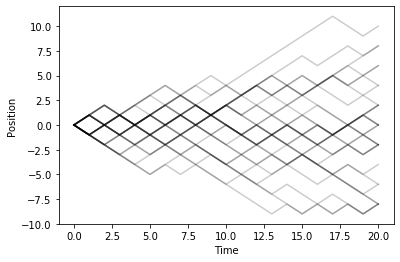

In [195]:
from matplotlib import pyplot as plt
initial_return = agent.evaluate(1000)
print("Initial return: %s"%(initial_return))
initial_samples = agent.samples(30)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.xlabel("Time")
plt.ylabel("Position")
plt.show()

We then train the policy using our returns based algorithm, plotting its per-episode return and a running estimate of the return as it learns.

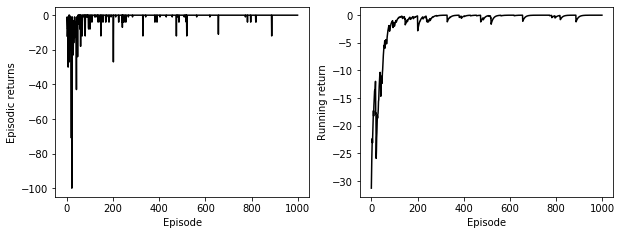

In [196]:
episodes = 1000
agent.train(episodes)
plt.figure(figsize = (10, 3.5))
plt.subplot(121)
plt.plot(agent.returns, c = 'k')
plt.xlabel("Episode")
plt.ylabel("Episodic returns")
plt.subplot(122)
plt.plot(agent.average_returns, c = 'k')
plt.xlabel("Episode")
plt.ylabel("Running return")
plt.show()

We finish by evaluating the learnt policy, comparing its average return and the samples it generates with the untrained policy.

Initial return: -33.459999999999994, Final return: -0.04399999999999994


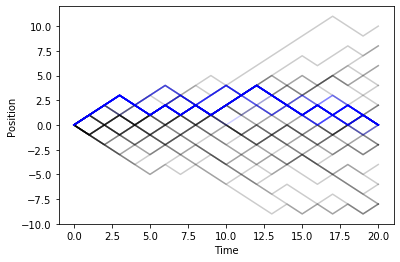

In [197]:
final_return = agent.evaluate(1000)
print("Initial return: %s, Final return: %s"%(initial_return, final_return))
samples = agent.samples(30)
plt.plot(np.array(initial_samples)[:,:,0].T, c = 'k', alpha = 0.2)
plt.plot(np.array(samples)[:,:,0].T, c = 'b', alpha = 0.2)
plt.xlabel("Time")
plt.ylabel("Position")
plt.show()